# Anomaly Detection

Anomaly detection on public spending recovered from Portal da Transparência.

<img src="img/anomalies_detected.jpg" align="center">

### Imports

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import scipy as sc
import yaml
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

#import warnings
#warnings.filterwarnings("ignore")

In [2]:
# Lendo as configurações
with open('.\configurations.yml') as file:
    configurations = yaml.load(file, Loader=yaml.FullLoader)

### Exploratory Data Analysis (EDA)

In [3]:
db = sqlite3.connect(configurations["Database"]["Path"]) # connecting to sqlite database

In [4]:
df = pd.read_sql_query("SELECT * FROM CARTOES", db)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17940 entries, 0 to 17939
Data columns (total 55 columns):
index                              17940 non-null int64
id                                 17940 non-null int64
mesExtrato                         17940 non-null object
dataTransacao                      17940 non-null object
valorTransacao                     17940 non-null float64
id_tipoCartao                      17940 non-null int64
codigo_tipoCartao                  17940 non-null object
descricao_tipoCartao               17940 non-null object
numeroInscricaoSocial              17940 non-null object
nome_estabelecimento               17940 non-null object
razaoSocialReceita                 17940 non-null object
nomeFantasiaReceita                17940 non-null object
localidadePessoa                   17940 non-null object
dataAbertura                       17940 non-null object
enderecoEletronico                 17940 non-null object
numeroTelefone                     179

In [6]:
df.head()

,index,id,mesExtrato,dataTransacao,valorTransacao,id_tipoCartao,codigo_tipoCartao,descricao_tipoCartao,numeroInscricaoSocial,nome_estabelecimento,...,nome_orgaoVinculado,codigoSIAFI,cnpj,sigla_orgaoVinculado,descricaoPoder,codigo_orgaoMaximo,sigla_orgaoMaximo,nome_orgaoMaximo,codigoFormatado_portador,nome_portador
0,0,151041007,10/2019,18/09/2019,9.00,1,1,Cartão de Pagamento do Governo Federal - CPGF,,ZOOP TECNOLOGIA E MEIOS DE PAGAMENTO S.A.,...,Instituto Federal Catarinense,26422,10635424000186,IFC,EXECUTIVO,26000,MEC,Ministério da Educação,***.857.959-**,HORALDO ANTONIO BRANDALISE
1,1,151041008,09/2019,02/08/2019,20.00,1,1,Cartão de Pagamento do Governo Federal - CPGF,-1,SEM INFORMACAO,...,Ministério da Economia - Unidades com vínculo ...,25000,00394460000141,ME,EXECUTIVO,25000,ME,Ministério da Economia,***.646.795-**,JOAO VICTOR BARBOSA DE MATOS
2,2,151041009,04/2019,19/03/2019,609.38,1,1,Cartão de Pagamento do Governo Federal - CPGF,,M. L. COMERCIO E INDUSTRIA DE ALUMINIO LTDA,...,Universidade Federal da Bahia,26232,15180714000104,UFBA,EXECUTIVO,26000,MEC,Ministério da Educação,***.483.205-**,ANTONIO CARLOS SAMPAIO AMARAL
3,3,151041010,08/2019,09/07/2019,389.60,1,1,Cartão de Pagamento do Governo Federal - CPGF,-1,SEM INFORMACAO,...,Hospital de Clínicas de Porto Alegre,26294,87020517000120,HCPA,EXECUTIVO,26000,MEC,Ministério da Educação,***.877.890-**,ALROUCIAN SANTOS DA MOTTA
4,4,151041011,04/2019,13/03/2019,14.99,1,1,Cartão de Pagamento do Governo Federal - CPGF,,ATACADO DA CONSTRUCAO LTDA,...,Advocacia-Geral da União - Unidades com víncul...,63000,26994558000123,AGU,EXECUTIVO,63000,AGU,Advocacia-Geral da União,***.449.134-**,SENISE LIRA MONTENEGRO


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
index,17940.0,8.969500e+03,5178.976250,0.0,4.484750e+03,8.969500e+03,1.345425e+04,17939.0
id,17940.0,1.515645e+08,325391.368639,151041007.0,1.512507e+08,1.515511e+08,1.518471e+08,152141112.0
valorTransacao,17940.0,6.879527e+02,3347.852742,-4670.4,1.750000e+02,5.017800e+02,9.500350e+02,342000.0
id_tipoCartao,17940.0,1.621906e+00,0.591219,1.0,1.000000e+00,2.000000e+00,2.000000e+00,3.0


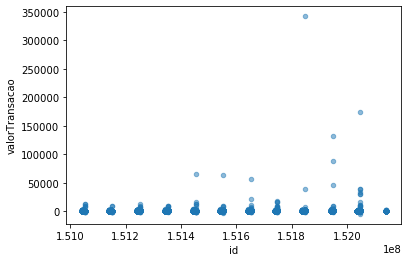

In [8]:
df.plot.scatter("id", "valorTransacao", alpha=0.5)

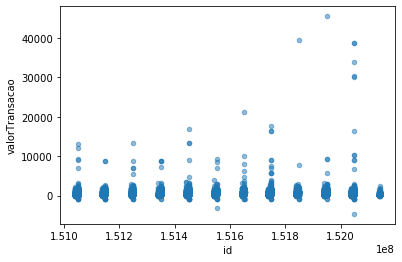

In [9]:
df[df.valorTransacao < 50000].plot.scatter("id", "valorTransacao", alpha=0.5)

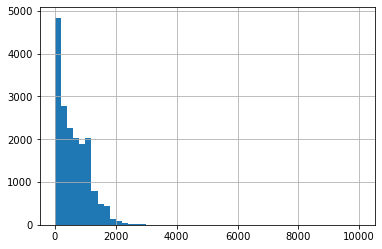

In [10]:
df.valorTransacao.hist(range=(0, 10000), bins=50)

In [11]:
df.valorTransacao.sort_values()

17485     -4670.40
9466      -3078.39
9524      -1000.00
15881     -1000.00
1565      -1000.00
           ...    
7723      64600.00
15892     87584.00
15879    132799.32
17500    173791.56
14156    342000.00
Name: valorTransacao, Length: 17940, dtype: float64

In [12]:
df.valorTransacao.sort_values(ascending=False)

14156    342000.00
17500    173791.56
15879    132799.32
15892     87584.00
7723      64600.00
           ...    
1565      -1000.00
15881     -1000.00
9524      -1000.00
9466      -3078.39
17485     -4670.40
Name: valorTransacao, Length: 17940, dtype: float64

In [13]:
len(df[df.valorTransacao <= 0])

49

### Feature Engeneering

- Número de Gastos no (Último mês/Semestre/...)
- Quantidade de Gastos com valores iguais (Último mês/Semestre...)
- Transações de mesma categoria no mesmo dia (Capturando similaridades)
- Horários próximos de transações similares

### Anomaly Detection

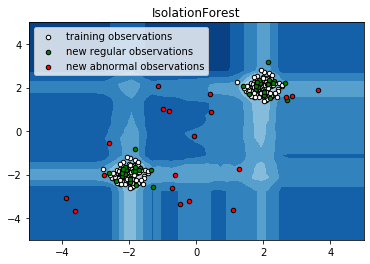

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

rng = np.random.RandomState(42)

# Generate train data
X = 0.3 * rng.randn(100, 2)
X_train = np.r_[X + 2, X - 2] # concatenate arrays quickly
# Generate some regular novel observations
X = 0.3 * rng.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = rng.uniform(low=-4, high=4, size=(20, 2))

# fit the model
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white',
                 s=20, edgecolor='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green',
                 s=20, edgecolor='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red',
                s=20, edgecolor='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([b1, b2, c],
           ["training observations",
            "new regular observations",
            "new abnormal observations"],
           loc="upper left")
plt.show()

In [15]:
# 3D Isolation Forest Test
model = IsolationForest()

X = rng.randn(100, 3) # random creation of 3D array with normal distribution
X_train = np.r_[X + 2, X - 2]
X_hzrd = rng.uniform(low=-5, high=4, size=(20, 2))

model.fit(X_train)
y_pred_train = model.predict(X_train)
y_pred_train

array([ 1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,
       -1,  1, -1,  1,  1, -1,  1, -1,  1,  1,  1, -1,  1, -1, -1, -1,  1,
        1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1, -1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,
       -1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  1, -1,  1, -1,  1,  1,  1,
        1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1])

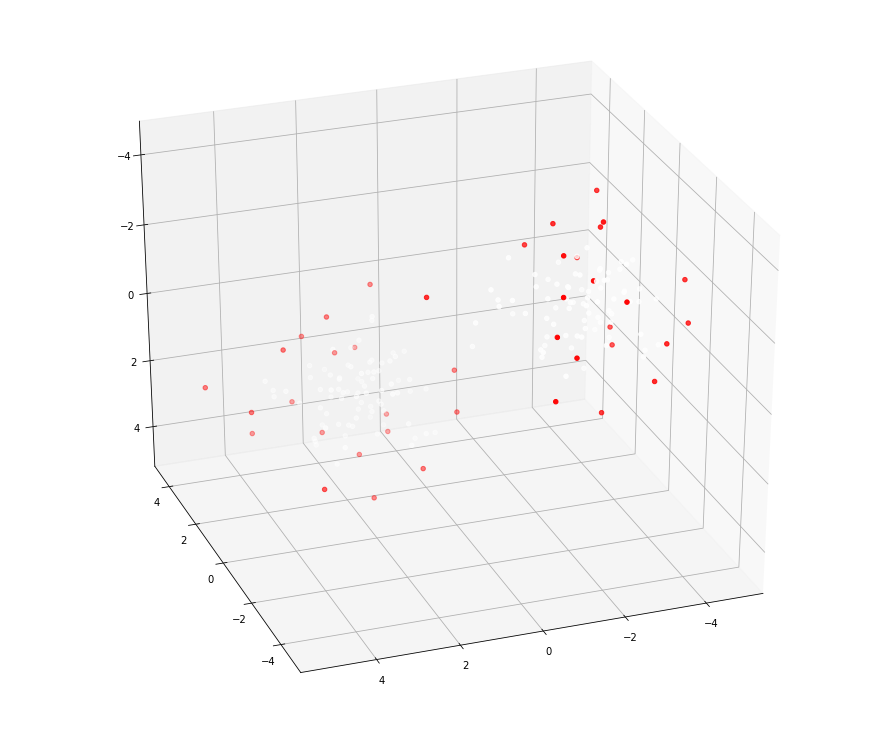

In [16]:
fig = plt.figure(1, figsize=(12, 10))
ax = Axes3D(fig, elev=-150, azim=110)

z = []

def nparrays(x):
    for i in x:
        if i == 1:
            z.append('white')
        else:
            z.append('red')
            
nparrays(y_pred_train)

z = np.array(z)
z.ravel()         
ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c=z, cmap=plt.cm.rainbow)

In [17]:
y_pred_train = clf.predict(X_hzrd)

In [18]:
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = ['a', 'b', 'c'],
                class_names = ['normal', 'anomaly'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
#from IPython.display import Image
#Image(filename = 'tree.png')

0

In [19]:
!dot -Tpdf tree.dot -o tree.pdf